# Test of word position extraction for Decoding the Civil War

In [1]:
import numpy as np
import scipy as sp
import astropy as ap
import pandas as pd
import matplotlib
import matplotlib.pyplot as mplplot
%matplotlib inline

import skimage
from skimage import io as skimio
from skimage import filters as skimfilt
from skimage import color as skimcolor
from skimage import morphology as skimmorph
from scipy import ndimage as spndimage
from scipy.signal import find_peaks_cwt

from imageModifiers import *
from readImages import *

## Pipeline adjustable parameters

In [2]:
dataset = 'DCW'
piplineParSets = {'DCW' : 
                  {
                      'pageBlurSigma' : 35.0,
                      'lineBlurSigma' : 4.0,
                      'wordBlurSigma' : 10.0,
                      'projectionEdgeTrimPixels' : 10,
                      'linePeakWidthRange' : (5, 30),
                      'wordPeakWidthRange' : (20,175),
                      'exampleSubjectUrl' : 'https://panoptes-uploads.zooniverse.org/production/subject_location/55b05e2a-a14c-40e7-be57-8d3480ec2dc8.jpeg'
                  },
                  'BOSTON': 
                  {
                      'pageBlurSigma' : 5.0,
                      'lineBlurSigma' : 7.0,
                      'wordBlurSigma' : 10.0,
                      'projectionEdgeTrimPixels' : 10,
                      'linePeakWidthRange' : (5, 30),
                      'wordPeakWidthRange' : (20,175),
                      'exampleSubjectUrl' : 'https://panoptes-uploads.zooniverse.org/production/subject_location/1e162b81-715d-495d-9b61-0ef7d9b7e735.jpeg'
                  }
                 }
pipelinePars = piplineParSets[dataset]
exampleSubjectUrl = pipelinePars['exampleSubjectUrl']
exampleSubjectUrl = 'https://panoptes-uploads.zooniverse.org/production/subject_location/088bb5aa-7265-4246-a784-59d1ad1793ee.jpeg'

plotit = True

## Algorithm
Load an example subject from the DCW dataset

In [3]:
let, grey = readImg(exampleSubjectUrl)

Extract the page with text on it. i.e. get rid of border

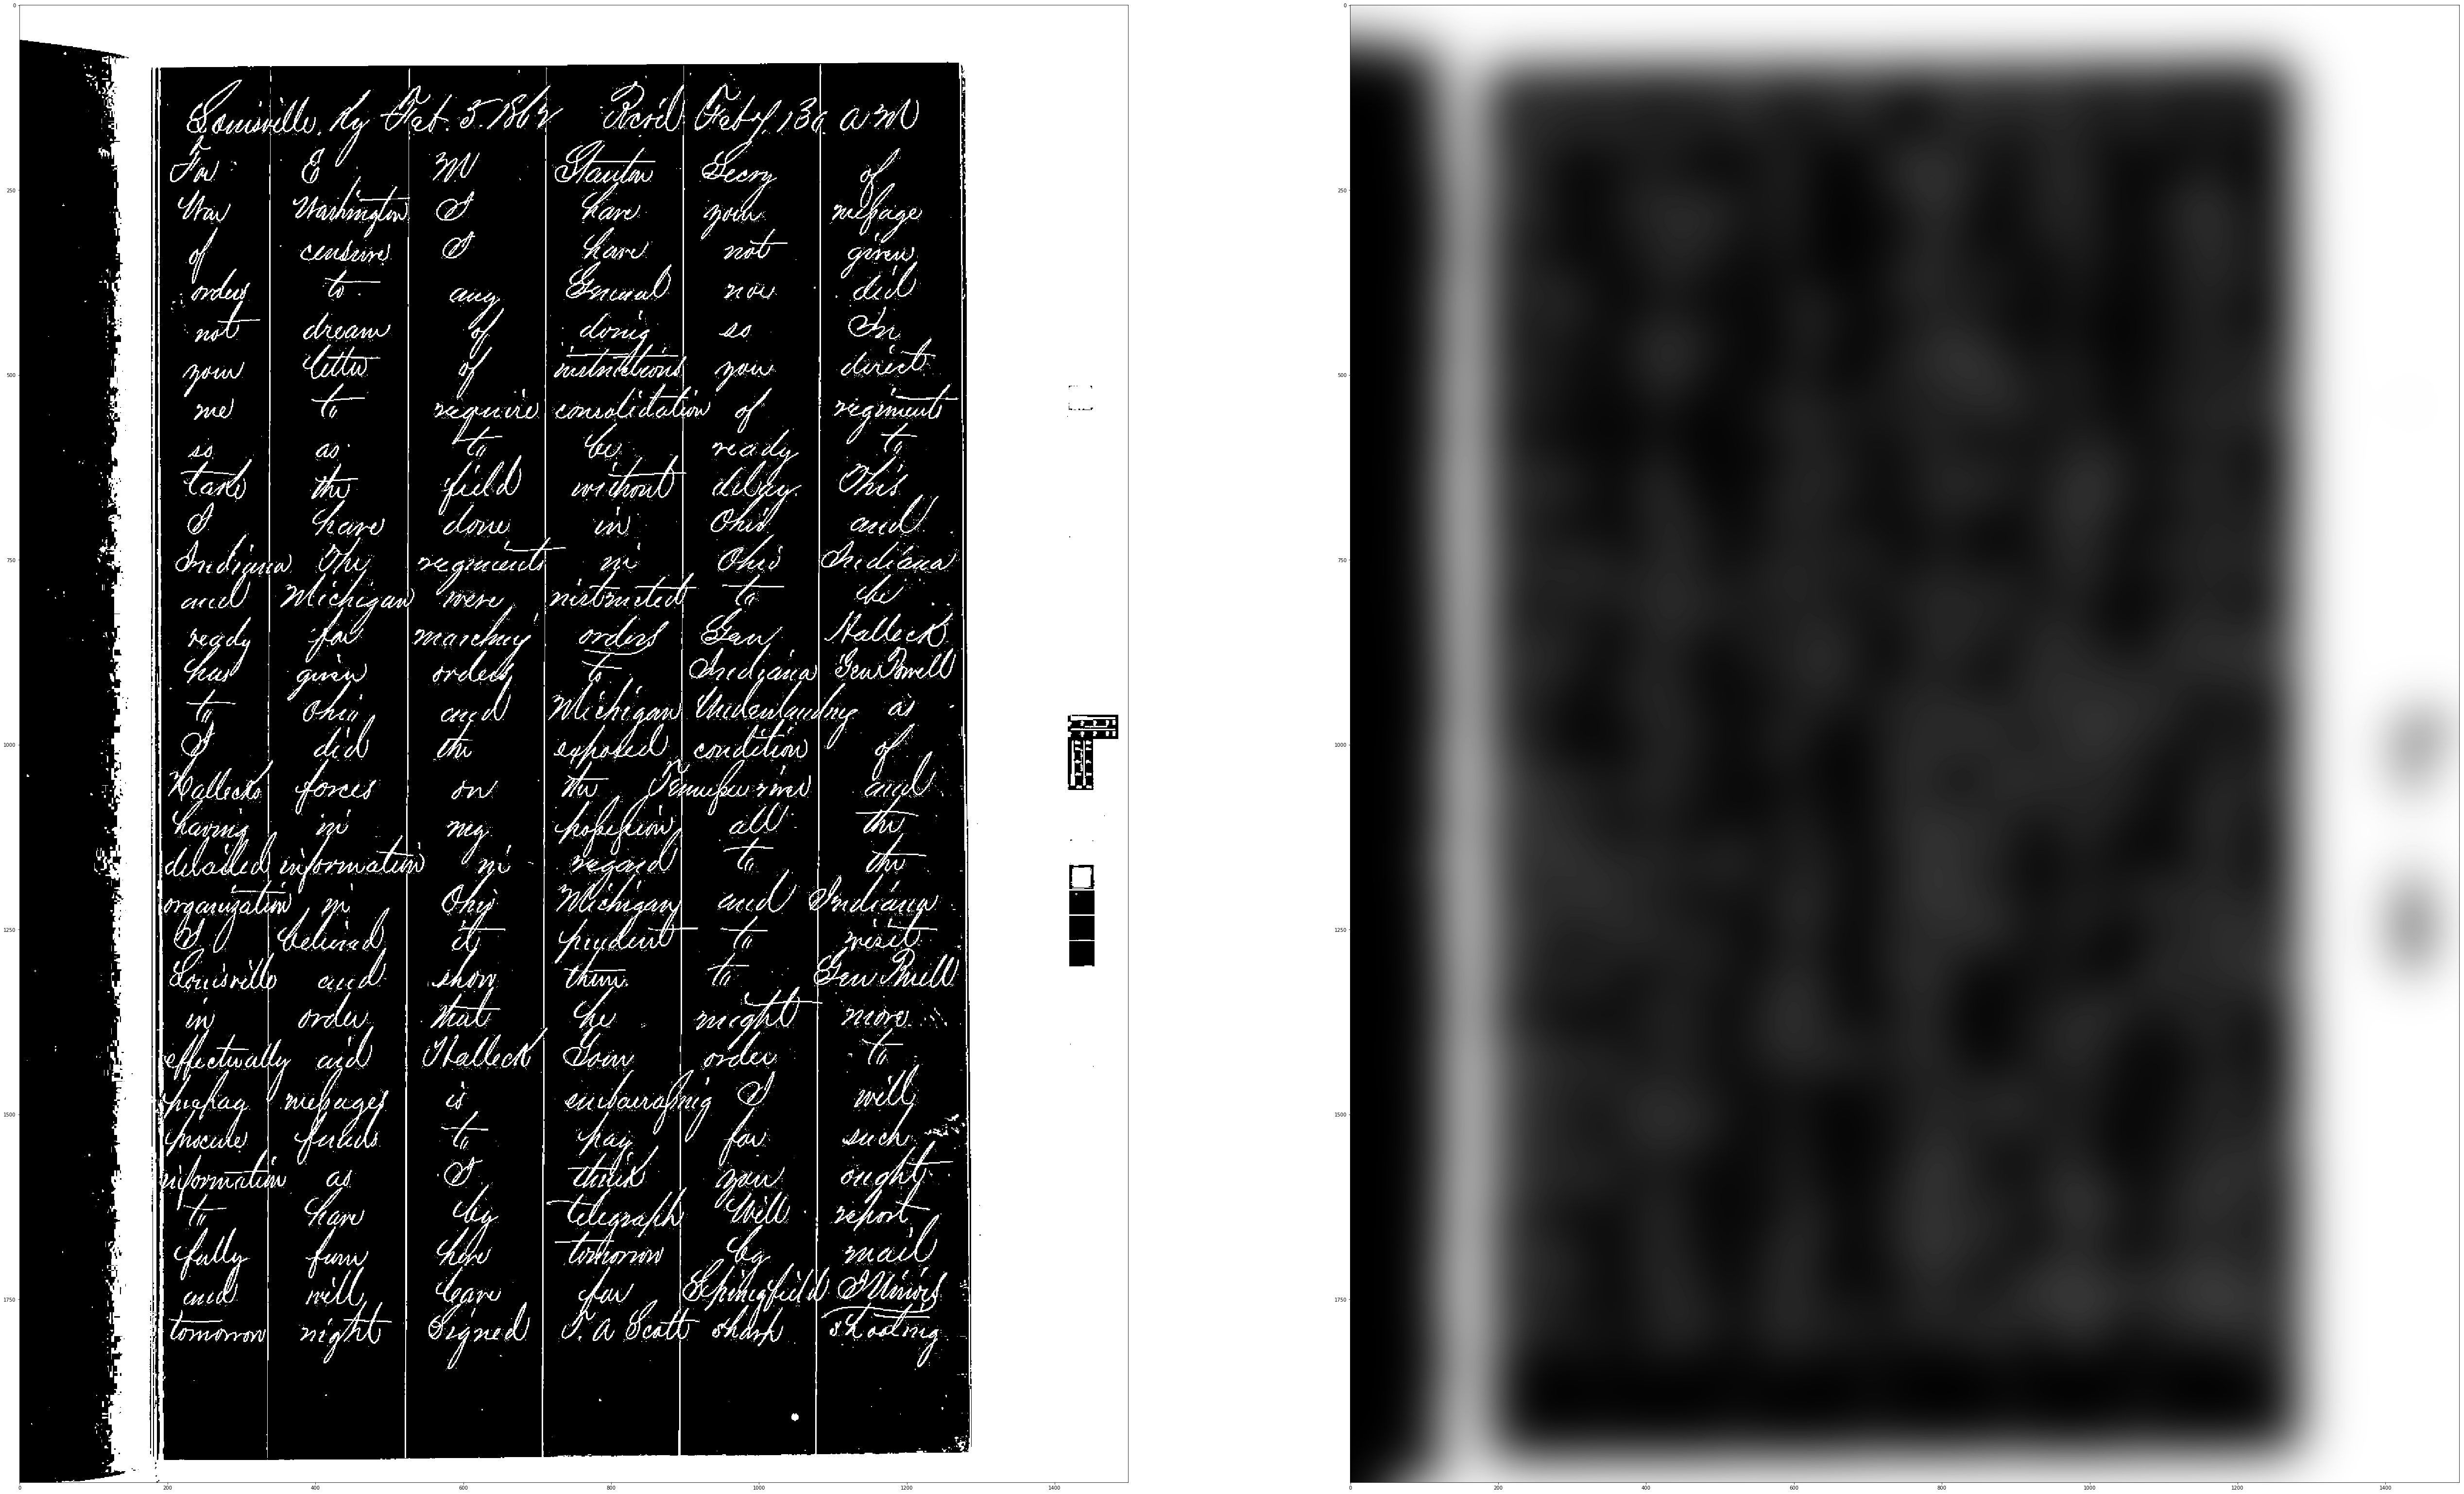

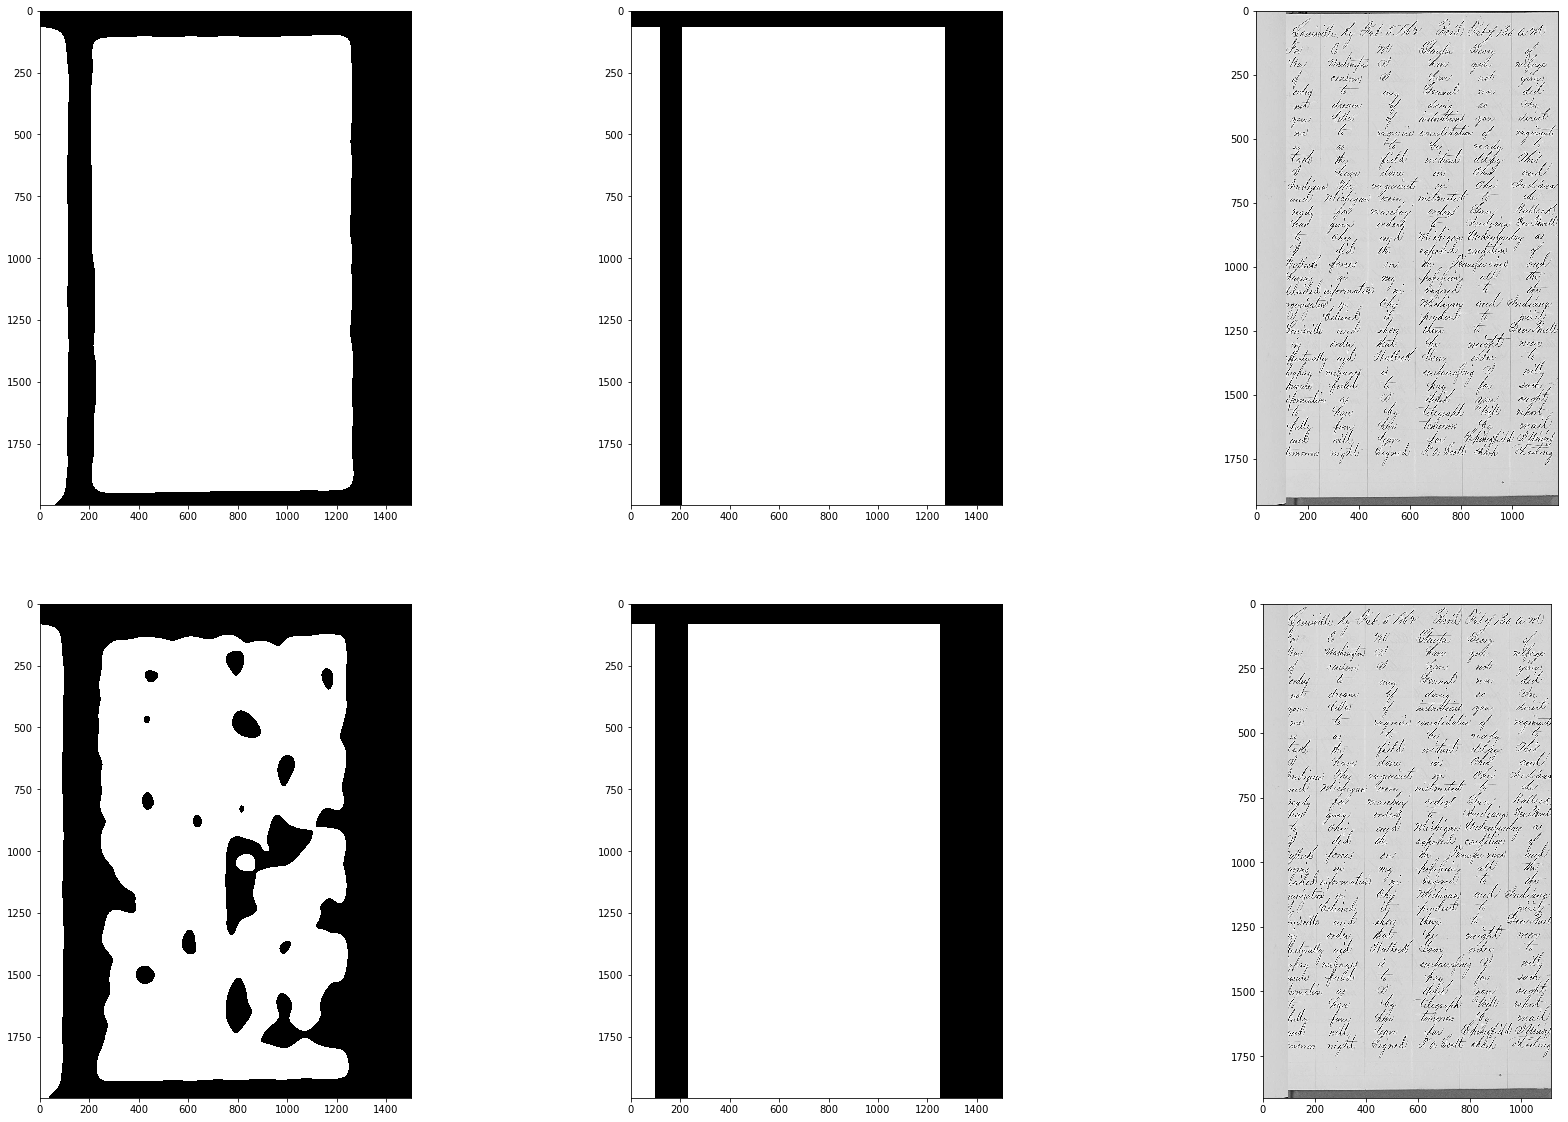

In [4]:
grey_trim, let_trim, trim_details = removeEdges(grey, let, pipelinePars['pageBlurSigma'], True)

Attempt to separate words and page by thresholding.

In [5]:
# level3Threshold_1 = { label : skimfilt.threshold_isodata(trimmedSubject) for label, trimmedSubject in grey_trimmed.items() }
# level3Mask_1 = { label : grey_trimmed[label] < threshold for label, threshold in level3Threshold_1.items() }
level3Mask_1 = { label : binarizeImg(grey_trim[label], skimfilt.threshold_isodata)
                for label in trim_details['level2TrimLevels'] }
blurredLevel3Mask_1 = {label : skimfilt.gaussian(mask, sigma=pipelinePars['lineBlurSigma'], multichannel=False) for label, mask in level3Mask_1.items() } 

# level3Threshold = { label : skimfilt.threshold_otsu(trimmedSubject) for label, trimmedSubject in grey_trimmed.items() }
# level3Mask = { label : grey_trimmed[label] < threshold for label, threshold in level3Threshold.items() }
level3Mask = { label : binarizeImg(grey_trim[label], skimfilt.threshold_otsu)
              for label in trim_details['level2TrimLevels'] }
blurredLevel3Mask = {label : skimfilt.gaussian(mask, sigma=pipelinePars['lineBlurSigma'], multichannel=False) for label, mask in level3Mask.items() } 

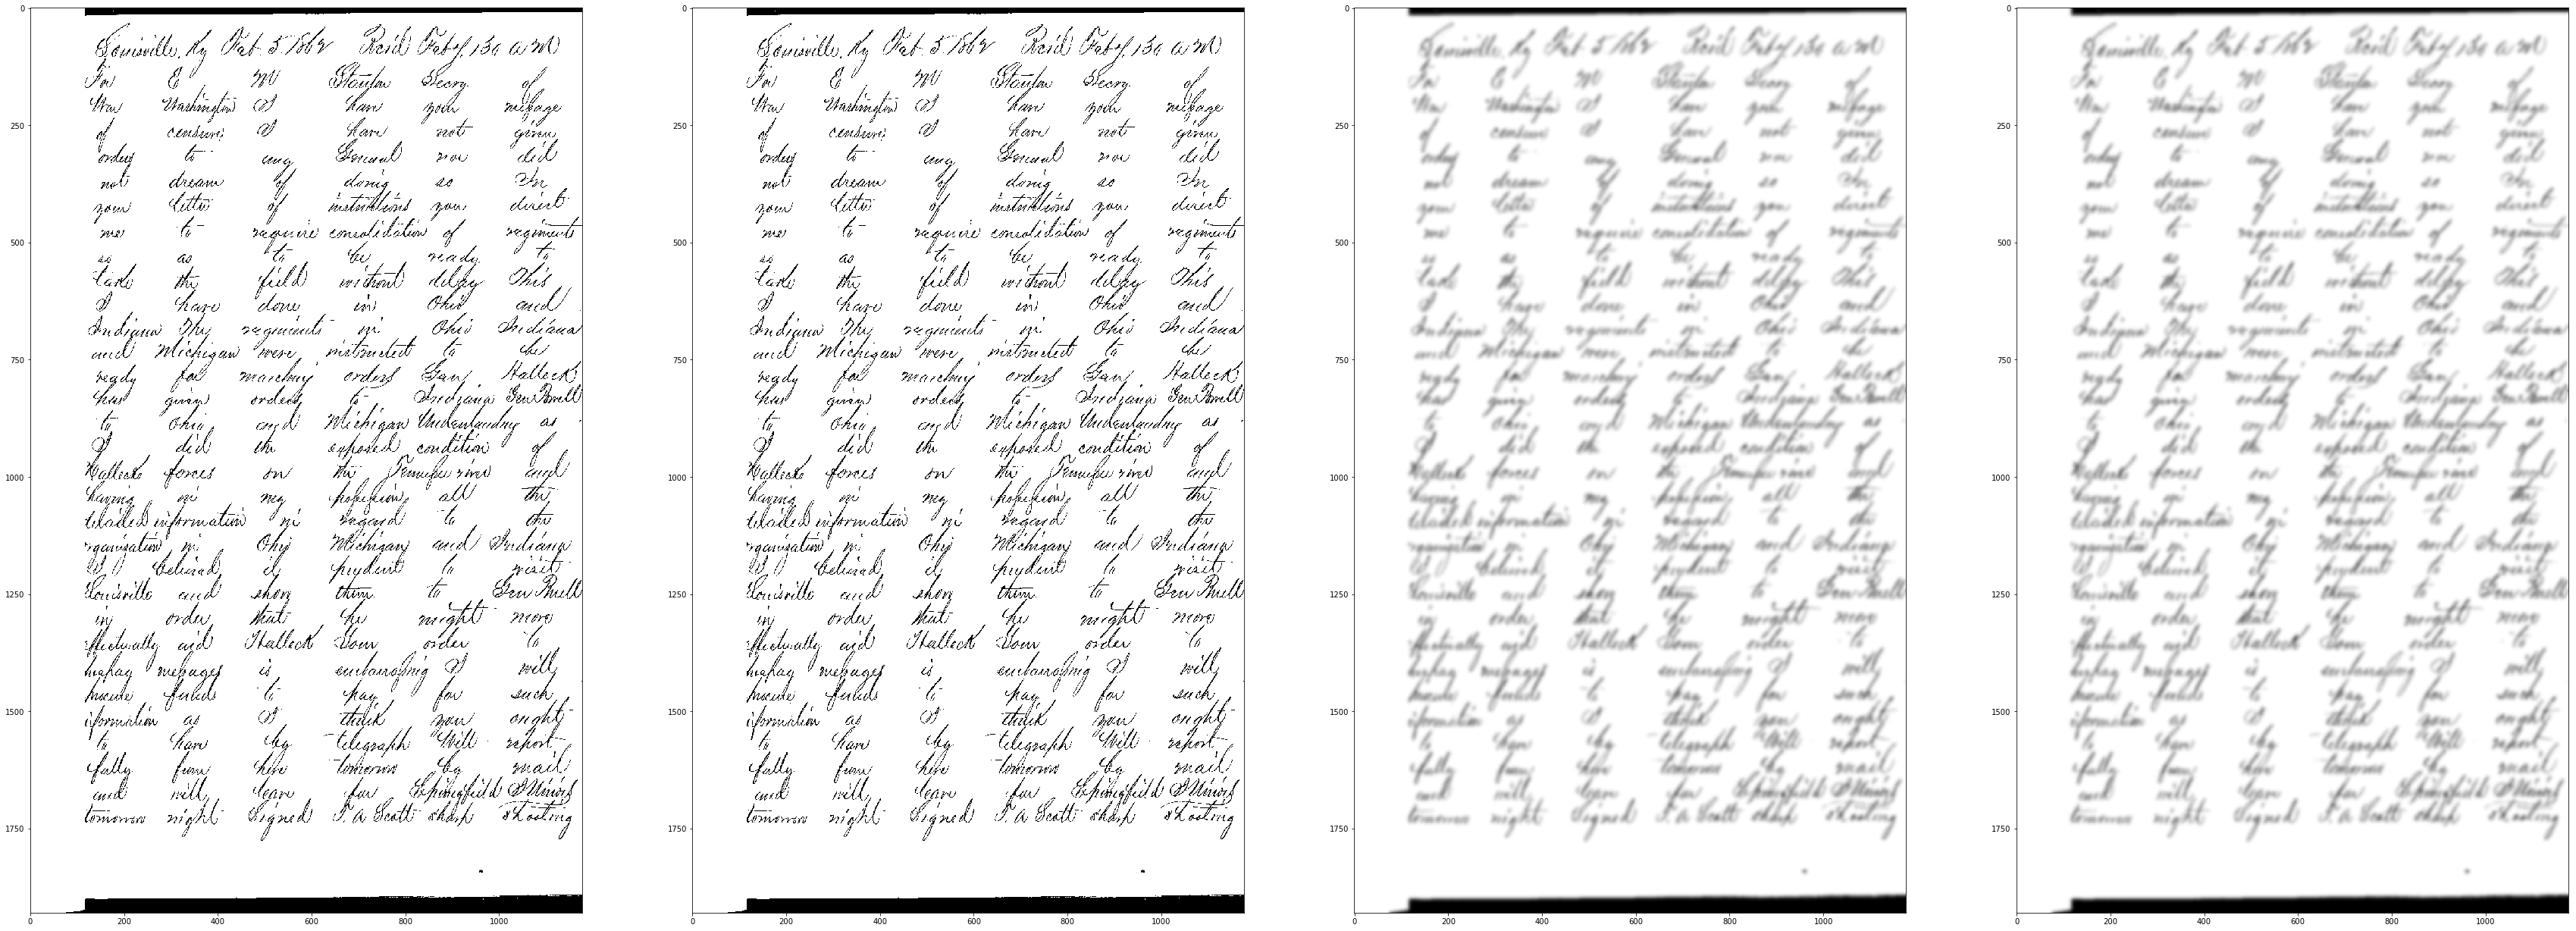

In [6]:
subjectFigure, subjectAxes = mplplot.subplots(figsize=(60, 40), ncols=4, nrows=1)

subjectAxes.flatten()[0].imshow(level3Mask['soft'], cmap = 'gray')
subjectAxes.flatten()[1].imshow(level3Mask_1['soft'], cmap = 'gray')
subjectAxes.flatten()[2].imshow(blurredLevel3Mask['soft'], cmap = 'gray')
subjectAxes.flatten()[3].imshow(blurredLevel3Mask['soft'], cmap = 'gray')

Find line positions by projecting thresholded image onto Y axis and finding peaks in the projection in the **hard** trimmed image.

(1892, 1094) (1912, 1114)


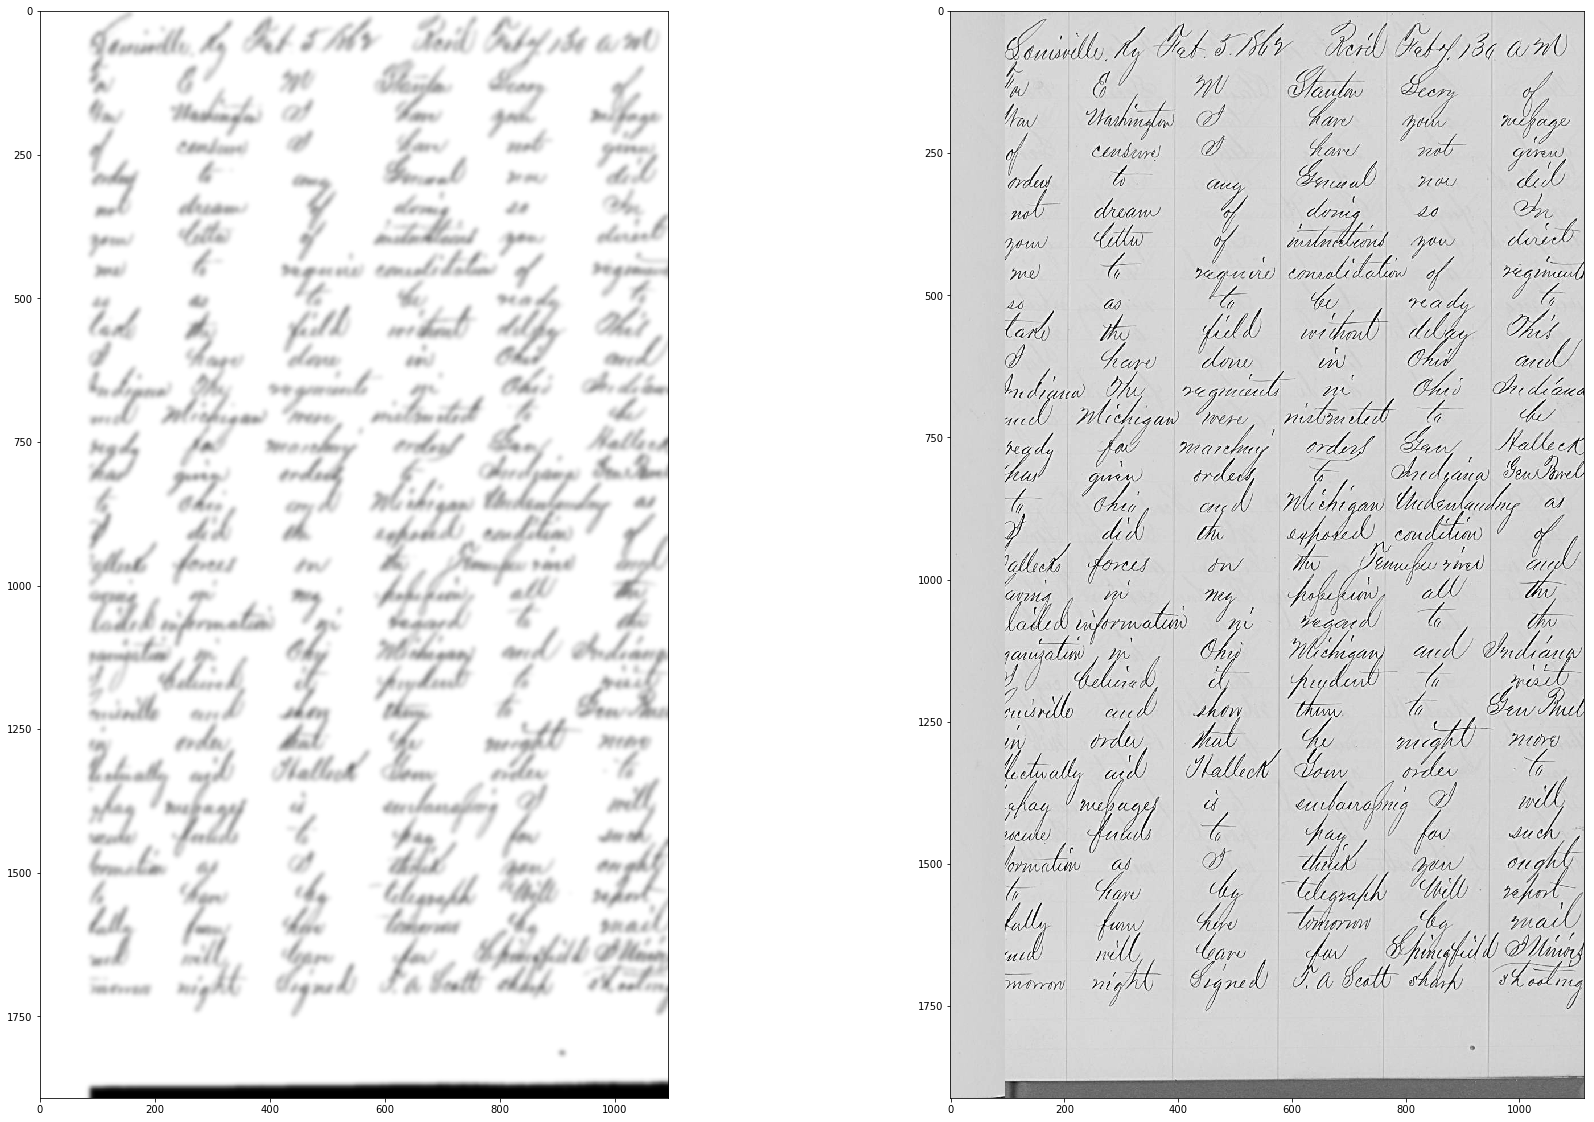

In [10]:
subjectFigure, subjectAxes = mplplot.subplots(figsize=(30, 20), ncols=2, nrows=1)
trimPix = pipelinePars['projectionEdgeTrimPixels']

subjectAxes.flatten()[0].imshow(blurredLevel3Mask['hard'][trimPix:-trimPix,trimPix:-trimPix], cmap='gray')
subjectAxes.flatten()[1].imshow(grey_trim['hard'], cmap='gray')

print(blurredLevel3Mask['hard'][trimPix:-trimPix,trimPix:-trimPix].shape,
      grey_trim['hard'].shape)

In [11]:
trimPix = pipelinePars['projectionEdgeTrimPixels']
yProjectedPixelDensity = np.sum(blurredLevel3Mask['hard'][trimPix:-trimPix,trimPix:-trimPix], axis=1)
xProjectedPixelDensity = np.sum(blurredLevel3Mask['hard'][trimPix:-trimPix,trimPix:-trimPix], axis=0)

lineIndices = find_peaks_cwt(vector=yProjectedPixelDensity, widths=np.arange(*pipelinePars['linePeakWidthRange']))
averageLineSeparation = np.average(np.diff(lineIndices))

Now locate likely words on each line.

In [12]:
wordIndices = []
wordChangePoints = []
meanWordChangePoints = []
segmentXProjections = []
for lineNumber, lineIndex in enumerate(lineIndices) :
    segment = level3Mask['hard'][max(0, int(lineIndex - averageLineSeparation/2)) : int(lineIndex + averageLineSeparation/2), trimPix:-trimPix]
    segmentXProjections.append(np.sum(skimfilt.gaussian(segment > 0, sigma=pipelinePars['wordBlurSigma'], multichannel=False), axis=0))
    superThresholdIndices = segmentXProjections[-1] > 0.1*np.amax(segmentXProjections[-1]) 
    segmentXProjections[-1] = 10*superThresholdIndices.astype(int)
    wordChangePoints.append(np.where(segmentXProjections[-1][:-1] != segmentXProjections[-1][1:]))
    meanWordChangePoints.append(wordChangePoints[-1][:-1] + wordChangePoints[-1][1:])
#     print(type(wordChangePoints[-1]), np.array(wordChangePoints[-1]), wordChangePoints[-1][:-1] + wordChangePoints[-1][1:], sep='\n')
    wordIndices.append(find_peaks_cwt(vector=segmentXProjections[-1], 
                                      widths=np.arange(*pipelinePars['wordPeakWidthRange'])).tolist()
                      )

Assemble the X and Y coordinates of all detected words for all lines.

In [13]:
wordXIndices = np.concatenate(np.array(wordIndices))
wordYIndices = np.concatenate(np.array([[lineIndex]*len(lineWordIndices) for lineIndex, lineWordIndices in zip(lineIndices, wordIndices)]))

## Intermediate Result Plots

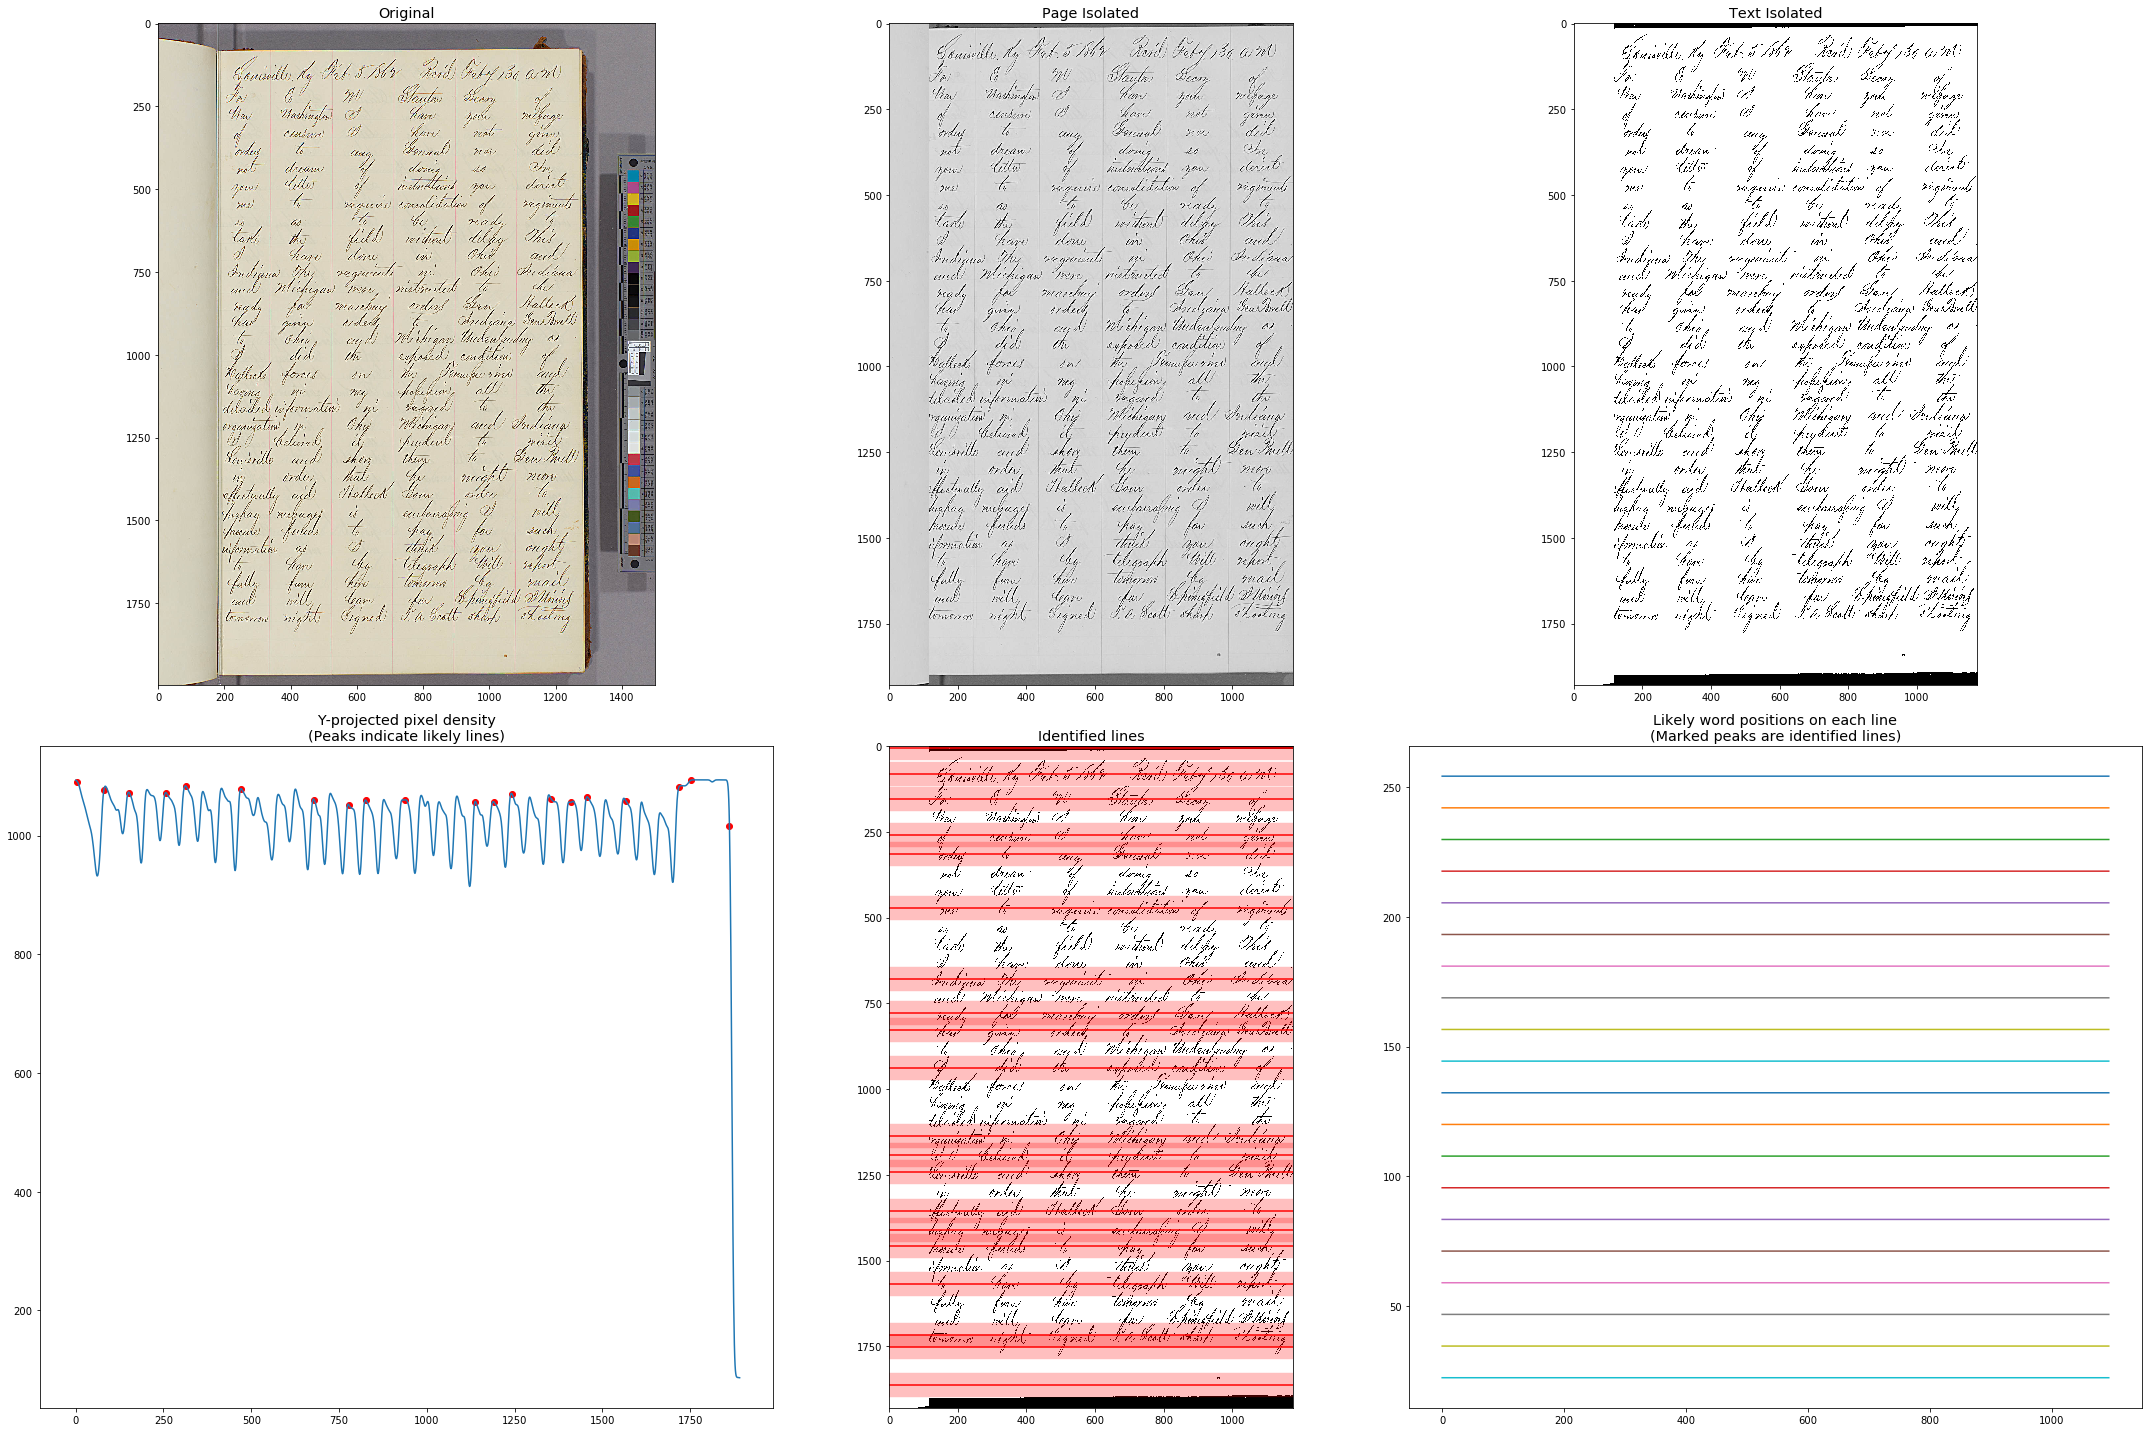

In [16]:
subjectFigure, subjectAxes = mplplot.subplots(figsize=(30, 20), ncols=3, nrows=2)

# plot the original image
originalFigure = subjectAxes.flatten()[0].imshow(let)
subjectAxes.flatten()[0].set_title('Original', fontsize='x-large')

# plot a trimmed luminance version of the image 
trimmedExampleSubjectFigure = subjectAxes.flatten()[1].imshow(grey_trim['soft'], cmap = 'gray')
subjectAxes.flatten()[1].set_title('Page Isolated', fontsize='x-large')

# plot a trimmed image thresholded to enhance word-page contrast
trimmedExampleSubjectFigure = subjectAxes.flatten()[2].imshow(level3Mask['soft'], cmap = 'gray')
subjectAxes.flatten()[2].set_title('Text Isolated', fontsize='x-large')

# Plot the pixel intensiy projected onto the Y-direction - Peaks indicate likely lines
subjectAxes.flatten()[3].plot(np.arange(len(yProjectedPixelDensity)), yProjectedPixelDensity)
subjectAxes.flatten()[3].scatter(lineIndices, yProjectedPixelDensity[lineIndices], c='r')
subjectAxes.flatten()[3].set_title('Y-projected pixel density\n(Peaks indicate likely lines)', fontsize='x-large')

# Overplot likely line positions on trimmed image
trimmedExampleSubjectFigure = subjectAxes.flatten()[4].imshow(level3Mask['soft'], cmap = 'gray')
subjectAxes.flatten()[4].set_title('Identified lines', fontsize='x-large')
level2TrimOffsets = trim_details['level2TrimOffsets']
executed = all(subjectAxes.flatten()[4].axhline(lineIndex + (level2TrimOffsets['hard'][1] - level2TrimOffsets['soft'][1]), c='r') for lineIndex in lineIndices)
executed = all(subjectAxes.flatten()[4].axhline(lineIndex + (level2TrimOffsets['hard'][1] - level2TrimOffsets['soft'][1]), c='r', lw=averageLineSeparation/4, alpha=0.25) for lineIndex in lineIndices)

# Plot the projected line-wise pixel intensity and the extracted word positions (peaks)
for lineNumber, (segmentXProjection, 
                 wordIndexList, 
                 wordChangePointList, 
                 meanWordChangePointList) in enumerate(zip(segmentXProjections, wordIndices, wordChangePoints, meanWordChangePoints)) :
    lineTailNumber = len(segmentXProjections) - lineNumber
    subjectAxes.flatten()[5].plot(np.arange(len(segmentXProjection)), segmentXProjection+(lineTailNumber*averageLineSeparation/8))
    subjectAxes.flatten()[5].scatter(wordIndexList, (segmentXProjection+(lineTailNumber*averageLineSeparation/8))[wordIndexList], marker='+')
    subjectAxes.flatten()[5].scatter(wordChangePointList, (segmentXProjection+(lineTailNumber*averageLineSeparation/8))[wordChangePointList], marker='o')
#     subjectAxes.flatten()[5].scatter(meanWordChangePointList, (segmentXProjection+(lineTailNumber*averageLineSeparation/8))[meanWordChangePointList], marker='o')
subjectAxes.flatten()[5].set_title('Likely word positions on each line\n(Marked peaks are identified lines)', fontsize='x-large')

mplplot.tight_layout()

## Final Results!
Overplot the extracted word coordinates on the page.

In [ ]:
resultFigure = mplplot.figure(figsize=(15, 15))
resultsAxes = resultFigure.add_subplot(111)
resultsAxes.imshow(level3Mask['soft'], cmap='gray')
resultsAxes.scatter(wordXIndices + (level2TrimOffsets['hard'][0] - level2TrimOffsets['soft'][0]), wordYIndices + (level2TrimOffsets['hard'][1] - level2TrimOffsets['soft'][1]), c='r')